# Анализ глобального игрового рынка



  В данном проекте предстоит работать с данными интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Мне нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
  Нужно будет спрогнозировать будущие продажи, определить самые прибильные жанры, платформы и регионы. Сделать анализ по регионам: жанров, платформ и количества продаж (портрет пользователя).

# Шаг 1: подключение библиотек и открытие файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats as st

In [2]:
strim_data = pd.read_csv('/datasets/games.csv')
display(strim_data.head())
display(strim_data.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

# Шаг 2: предобработка данных

Обнаружен неправильный формат года релиза, невеврный регистр названия столбцов и множество пропусков. Исправим в следующих этапах.

In [3]:
#Приведем названия столбцов к нижнему регистру
strim_data.columns = map(str.lower, strim_data.columns)
display(strim_data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Изменим формат даты в столбце с годом релиза 
strim_data['year_of_release'] = strim_data['year_of_release'].astype('Int64')

print(strim_data.info())
display (strim_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB
None


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


При попытке изменения данных оценок пользователей была получена ошибка из-за того, что в столбце содержится значение 'tbd'. Оно означает, что сейчас идет оценивание и по факту оценки нет, поэтому все 'tbd' можно заменить на NaN.

In [5]:
strim_data['user_score'] = strim_data['user_score'].replace('tbd', np.NaN)
strim_data['user_score'] = strim_data['user_score'].astype('float')
display(strim_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


None

Формат исправлен.

In [6]:
# Посчитаем дубликаты по нескольким столбцам
strim_data.name.str.lower()
strim_data.platform.str.lower()

data_duplicated = strim_data.duplicated(['name', 'platform', 'year_of_release']).sum()
data_duplicated


2

In [7]:
strim_data = strim_data.drop_duplicates(subset = ['name', 'platform', 'year_of_release'])

data_duplicated = strim_data.duplicated(['name', 'platform', 'year_of_release']).sum()
data_duplicated

0

Были обнаружены и удалены две строки-дубликата

In [8]:
# Посчитаем пропуски
print(strim_data.isna().sum())

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         9124
rating             6765
dtype: int64


In [9]:
#Проверим пропуски в столбце названий игр
strim_data[strim_data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


У нас были пропуска в имени и  в жанре. Оказалось, что эти пропуски содератся в одной строке. Удалим эту строку.

In [10]:
strim_data.drop([659],inplace=True)
strim_data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

In [11]:
strim_data[strim_data['year_of_release'].isna()]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [12]:
# check
# жизненный срок платформы

years_of_life = strim_data.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


Возьмем первую игру, в названии которой содержится год и проверим, выходила ли она на других платформах или в других странах

In [13]:
#strim_data.query('name == "Madden NFL 2004"')

Заполним пробелы в годе выхода годом из названия игры

In [15]:

# жизненный срок платформы

years_of_life = strim_data.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


Пропусков стало в два раза меньше, но игры с неизвестным годом не подойдут нам для дальнейшего анализа, так что удалим строки с такими играми.

In [16]:
strim_data.dropna(subset=['year_of_release'], inplace=True)
strim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Пропуски в значениях рейтингов оставим как есть, потому что заменять их средним будет неправильно и в последующем это отразится на исследовании

In [17]:
# Создадим новый столбец с суммарными продажами во всех регионах
strim_data['total_sales'] = strim_data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
display(strim_data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [18]:
# check
strim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


In [19]:
strim_data['rating'] = strim_data['rating'].fillna('TBD')

В данной части проекта были удалены дубликаты, изменены необходимые типы данных, изменен регистр названий столбцов и посчитаны общие продажи по регионам.

# Шаг 3: иследовательский анализ данных

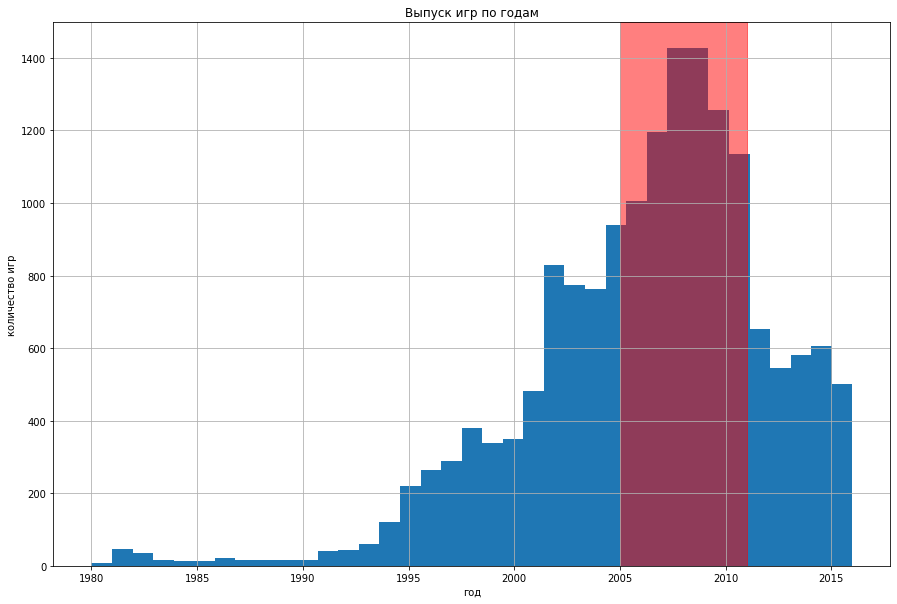

In [20]:
# Посмотрим сколько игр выходило в разные годы
strim_data['year_of_release'].hist(bins=37, grid=True, figsize=(15,10))
plt.title("Выпуск игр по годам")
plt.xlabel("год")
plt.ylabel("количество игр")
plt.axvspan(2005, 2011, color='red', alpha=0.5)

Данных с 1980 по 1993 годы мало, так что не будем их учитывать. Самое большое количество видеоигр выходило с 2005 по 2011 годы.

Посмотрим, как менялись продажи по платформам

Text(0, 0.5, 'Количество продаж')

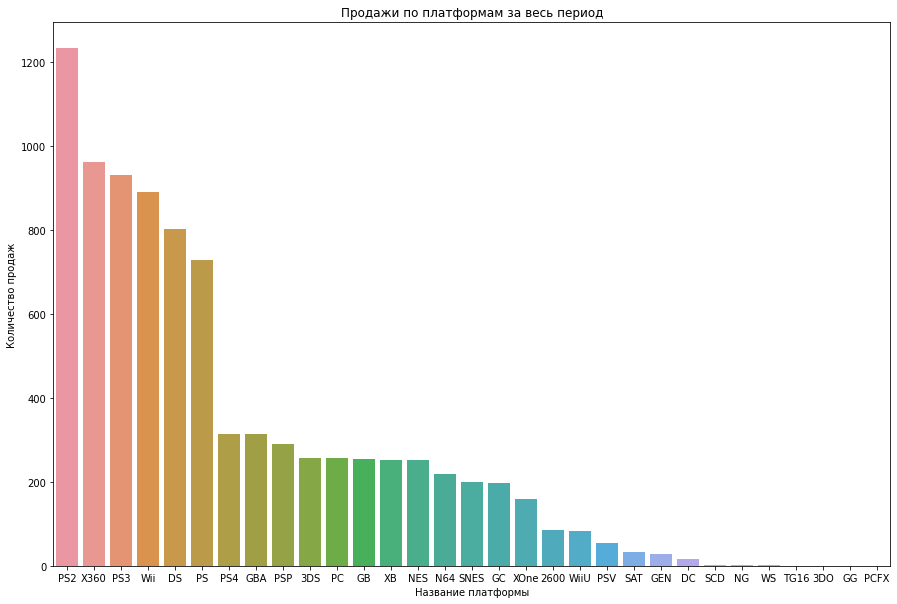

In [21]:
sales_on_platform = strim_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', 
    ascending=False)

plt.figure(figsize=(15,10))
sns.barplot(x=sales_on_platform.index,y=sales_on_platform['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Из графика следует, что чаще всего продавались игры на PS2, X360, PS3, Wii, DS и PS

Теперь определим срок "жизни" 10 топовых платформ

In [22]:

top_platform = sales_on_platform.sort_values(by='total_sales', ascending=False)[:10].index
top_platform

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'], dtype='object', name='platform')

Построим распределения продаж по годам для каждой платформы

In [23]:
#Удалим аномалию в продажах для платформы DS
data_ds = strim_data[(strim_data['platform'] == 'DS') & (strim_data['year_of_release'] < 2004)]
display(data_ds.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,TBD,0.02


In [24]:
strim_data.drop([15957],inplace=True)


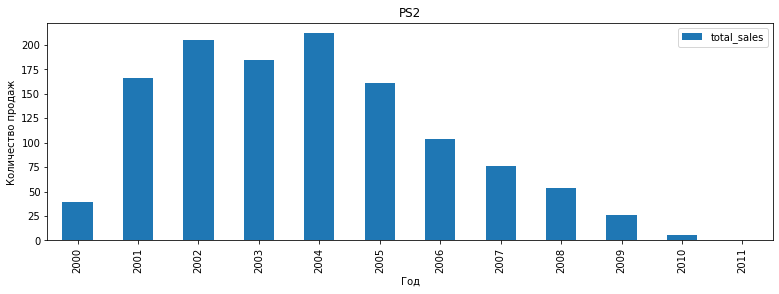

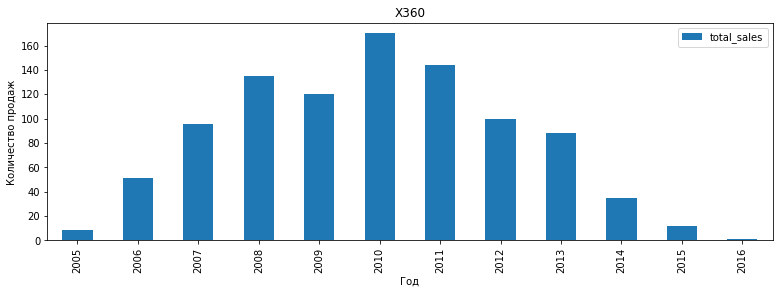

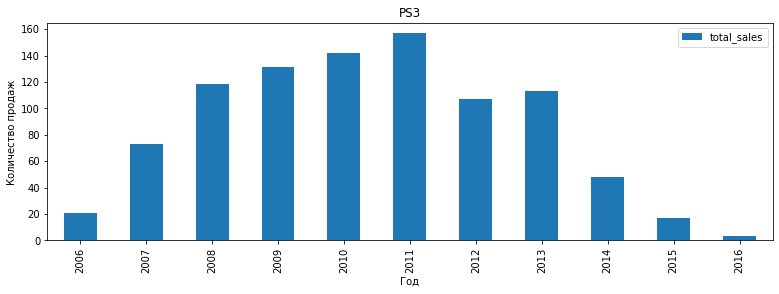

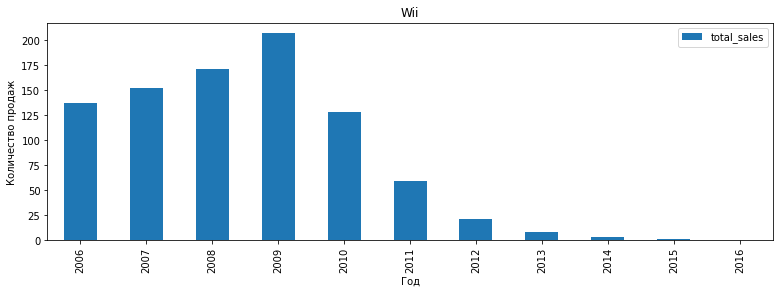

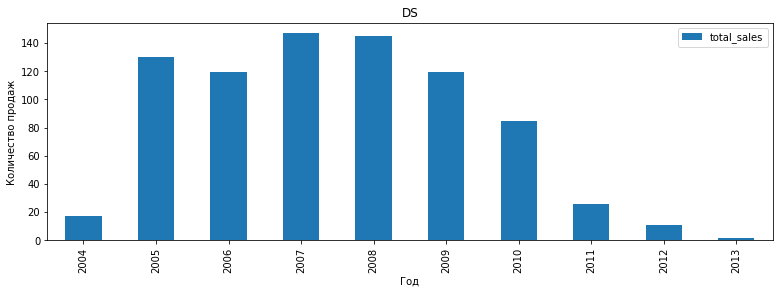

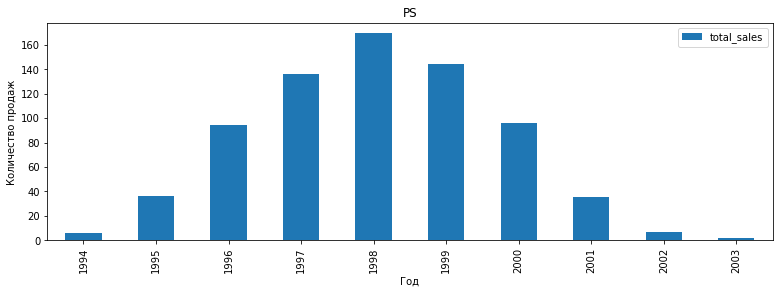

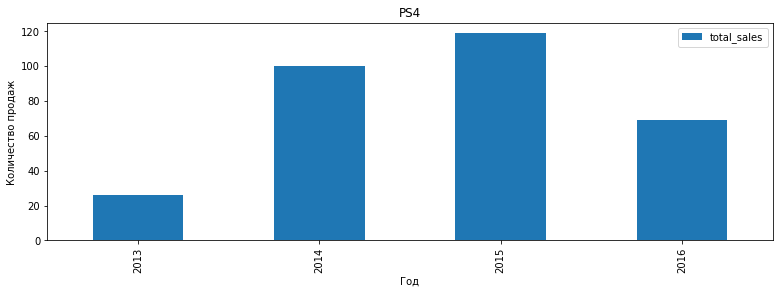

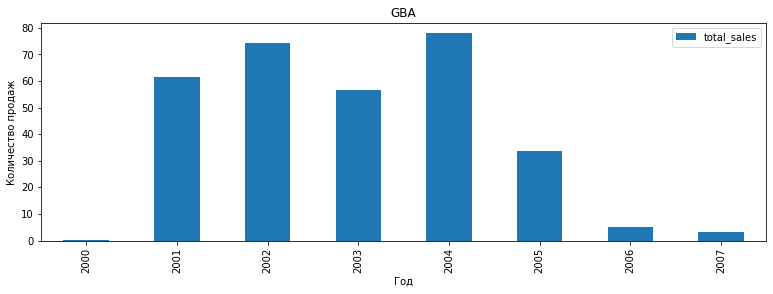

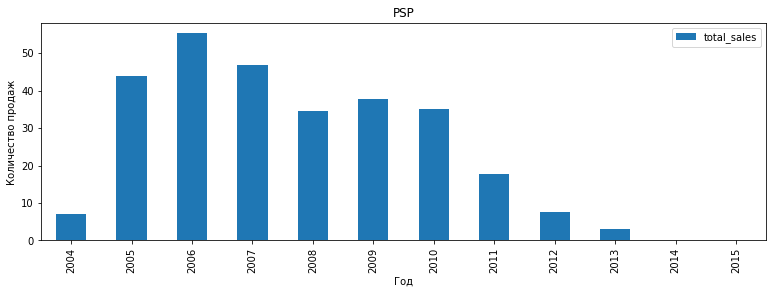

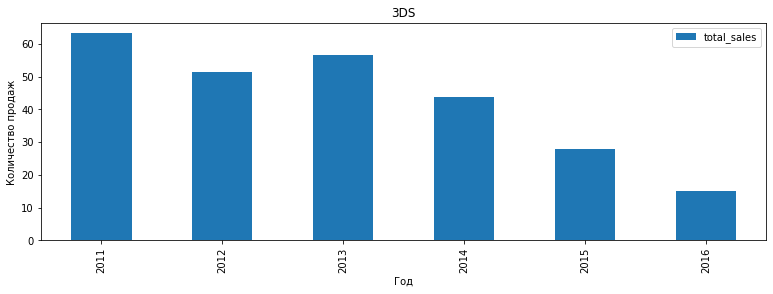

In [25]:
for platform in top_platform:
    strim_data[strim_data['platform'] == platform].pivot_table(index='year_of_release', 
        values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(13,4))
    plt.title(platform)
    plt.xlabel("Год")
    plt.ylabel("Количество продаж")

Средний срок, пока платформа остается актуальной, - 5-8 лет, а исчезает платформа примерно за 5 лет. Это связано с выходом новых версий, после чего старые становятся менее интересны, а также связано с тем, что современные игры выпускаются только на новые платформы. Про ПК такого сказать нельзя. На графике видно несколько пиков, которые можно соотнести со скачками в прогрессе ( создание интернета, эволюция компьютерной техники и т.д. ), которые в свою очередь задают новую тенденцию производителям игр. Однако,с 2011 года и тут заметен спад. Связано это может быть с большим распространением иных платформ.

#### Актуальным периодом будем считать последние 3 года с 2014 по 2016 годы, и, соответственно, отбросим все до 2013 года.

In [26]:
modern_data = strim_data[strim_data['year_of_release'] > 2013]
display(modern_data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,TBD,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,TBD,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,TBD,7.98


Построение ящика с усами по глобальным продажам игр в разбивке по платформам.

In [27]:
# Выделим из 10 топовых платформ актуальные в данный период времени и избавимся от выбросов
top_5_platform = ['XOne','3DS', 'WiiU', 'PS4', 'PC' ]
games_top_5_platform = modern_data[modern_data['platform'].isin(['XOne','3DS', 'WiiU', 'PS4', 'PC'])]
games_top_5_platform['total_sales'].describe()

count    1040.000000
mean        0.562712
std         1.272175
min         0.010000
25%         0.040000
50%         0.130000
75%         0.470000
max        14.630000
Name: total_sales, dtype: float64

In [28]:
# Посмотрим на общее количество вышедших игр на каждую платформу и на средние глобальные продажи
modern_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


Text(0, 0.5, 'Платформа')

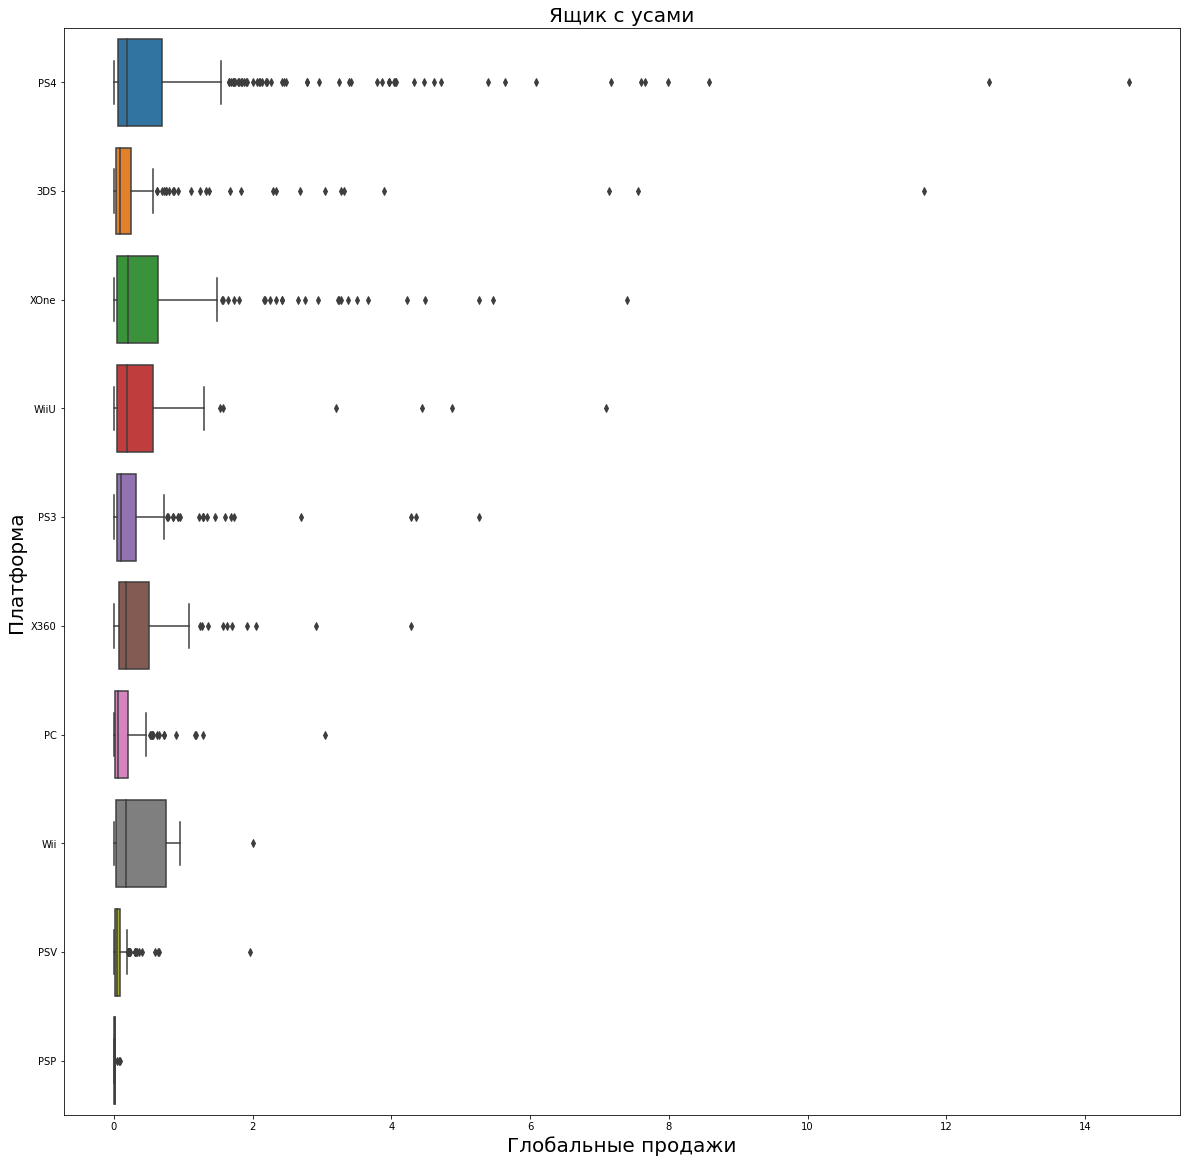

In [29]:
#Рисуем ящики с усами
plt.figure(figsize=(20,20))
sns.boxplot(data=modern_data, x='total_sales', y='platform', orient = "h")
plt.title('Ящик с усами', fontsize=20)
plt.xlabel('Глобальные продажи', fontsize=20)
plt.ylabel('Платформа',fontsize=20)

(0.0, 2.0)

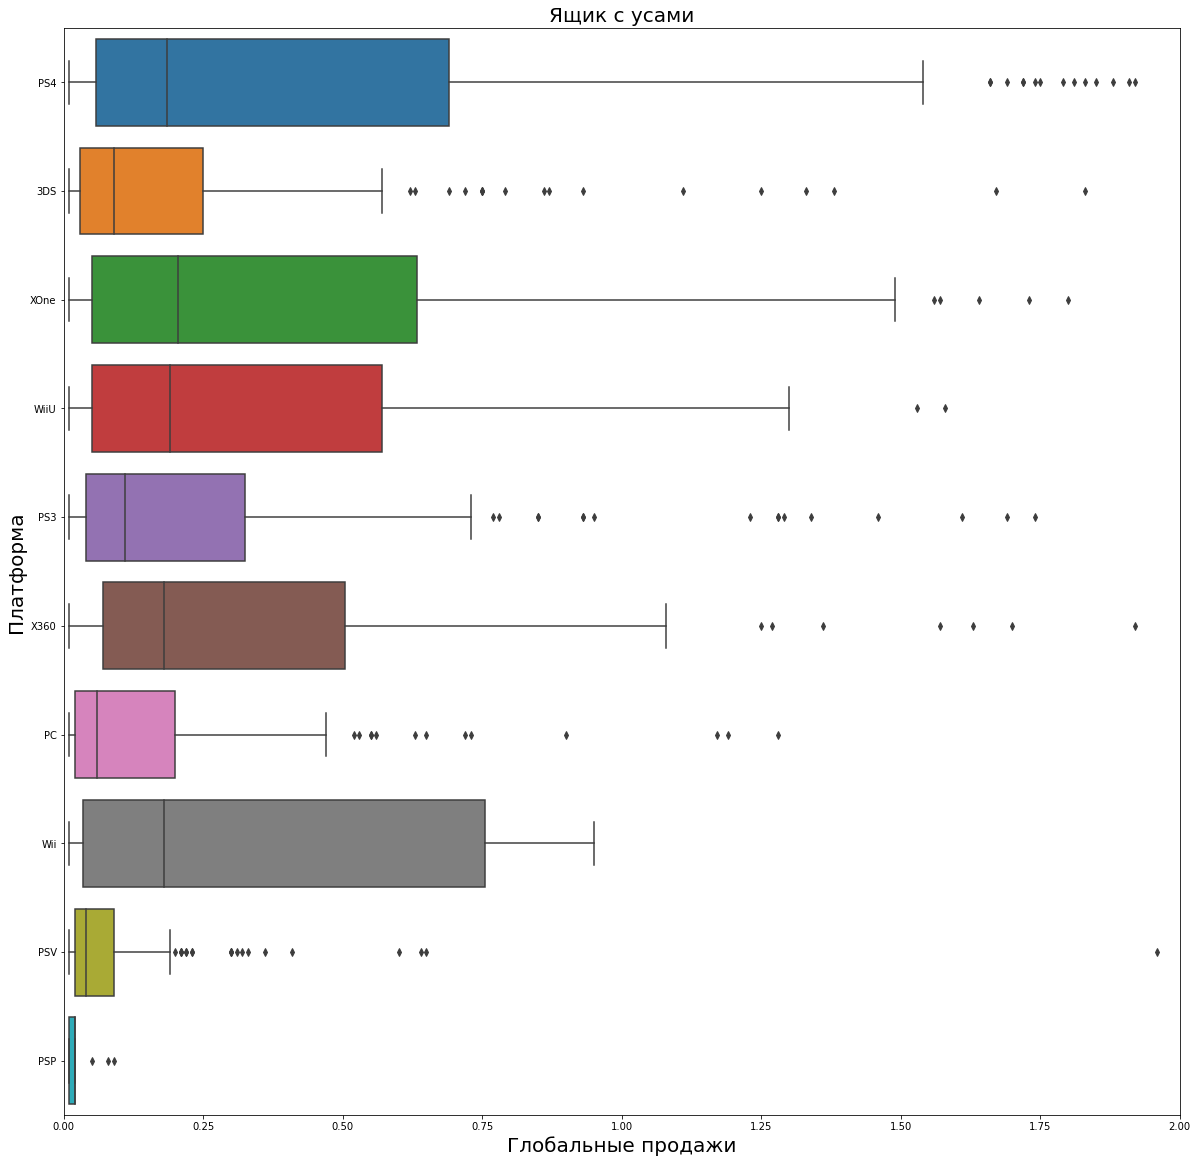

In [30]:
#Рисуем ящики с усами без выбросов
plt.figure(figsize=(20,20))
sns.boxplot(data=modern_data, x='total_sales', y='platform', orient = "h")
plt.title('Ящик с усами', fontsize=20)
plt.xlabel('Глобальные продажи', fontsize=20)
plt.ylabel('Платформа',fontsize=20)
plt.xlim(0, 2)

Из графика видно, что медианы у всех проходят по-разному. Больше всего продаж за выбранный период времени у PS4, X360, XOne и Wii. Меньше всего продавались игры для PSP и PSV.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [31]:
# Высчитаем корреляцию между оценками пользователей и продажами для PS4
sony_play_station_4 = strim_data[strim_data['platform']=='PS4']
print(sony_play_station_4['user_score'].corr(sony_play_station_4['total_sales']).round(2))

-0.03


Text(0.5, 1.0, 'Корреляция между оценками пользователей и продажами')

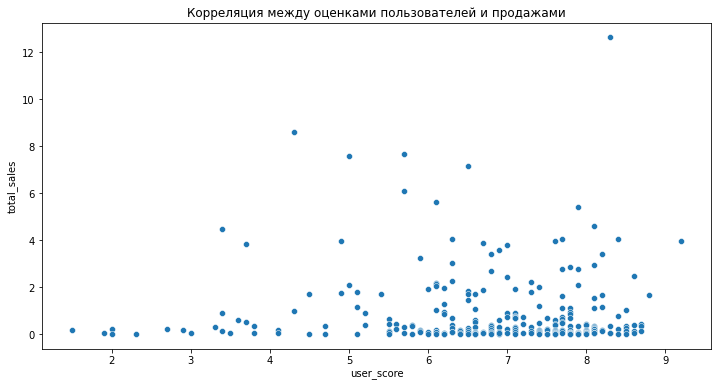

In [32]:
# Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=sony_play_station_4)
plt.title('Корреляция между оценками пользователей и продажами')

In [33]:
# Высчитаем корреляцию между оценками критиков и продажами для PS4
sony_play_station_4 = strim_data[strim_data['platform']=='PS4']
print(sony_play_station_4['critic_score'].corr(sony_play_station_4['total_sales']).round(2))


0.41


Text(0.5, 1.0, 'Корреляция между оценками критиков и продажами')

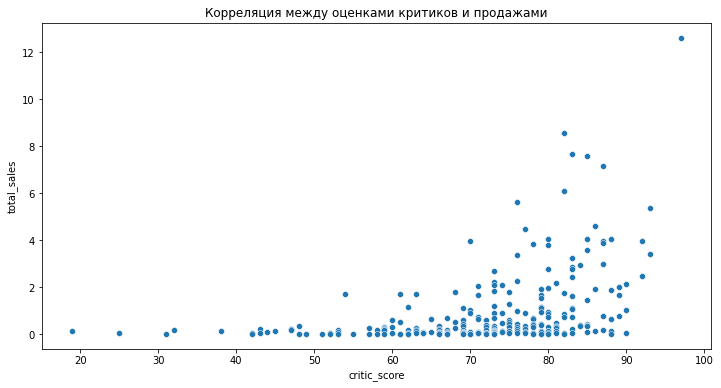

In [34]:
# Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=sony_play_station_4)
plt.title('Корреляция между оценками критиков и продажами')

Согласно полученным данным, можно сделать вывод, что продажи не связаны с оценками пользователей и слабо зависят от оценок критиков.

Соотнесём выводы с продажами игр на других платформах. PS4 исключим из топа, т.к. уже рассмотрели.

Text(0.5, 1.0, 'Корреляция между оценками критиков и продажами')

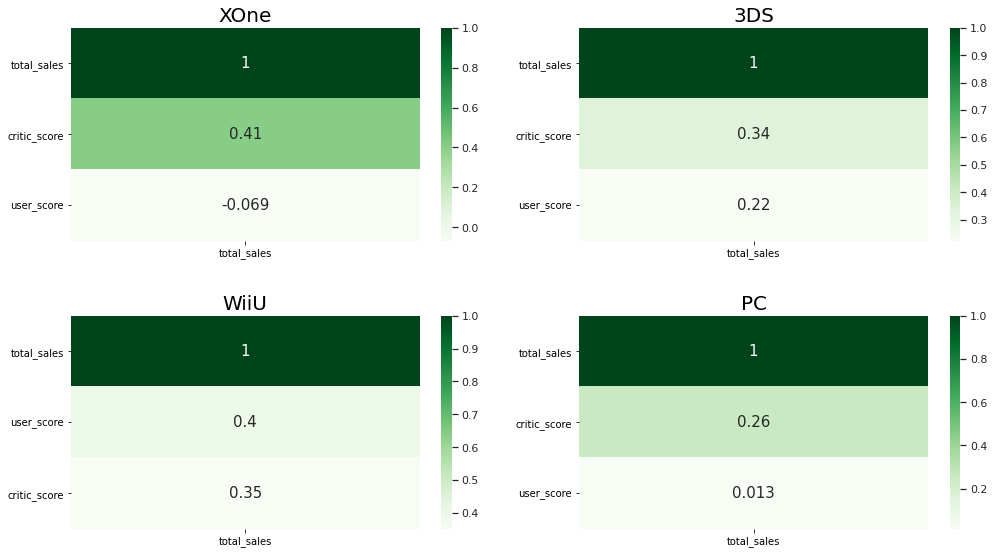

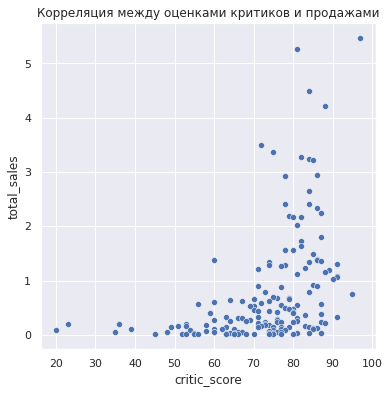

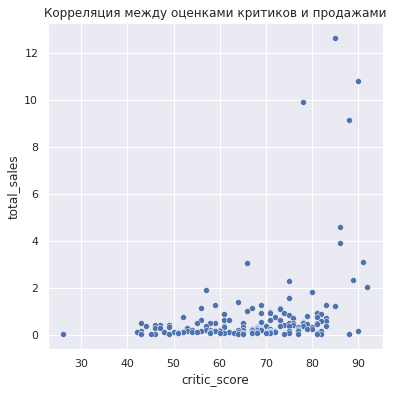

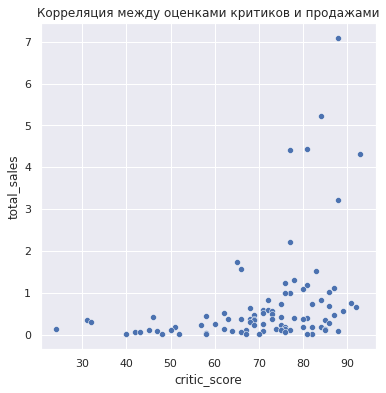

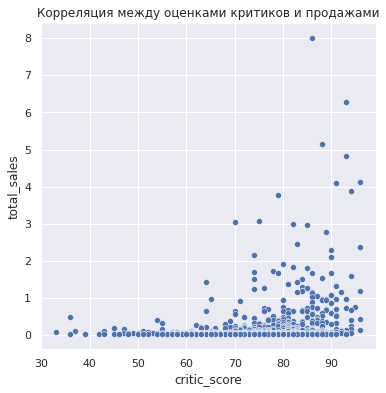

In [35]:
top_platforms = ['XOne','3DS', 'WiiU', 'PC']

rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = strim_data[(strim_data['platform'] == curr_platform) & (strim_data['user_score'] > 0)].copy()
        
        df_filtered = df_prep[['total_sales' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), 
                         cmap="Greens", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

# Диаграмма рассеяния для XOne
plt.figure(figsize=(6,6))
sns.scatterplot(x='critic_score', y='total_sales', data=strim_data[strim_data['platform']=='XOne'])
plt.title('Корреляция между оценками критиков и продажами')

# Диаграмма рассеяния для 3DS
plt.figure(figsize=(6,6))
sns.scatterplot(x='critic_score', y='total_sales', data=strim_data[strim_data['platform']=='3DS'])
plt.title('Корреляция между оценками критиков и продажами')

# Диаграмма рассеяния для WiiU
plt.figure(figsize=(6,6))
sns.scatterplot(x='critic_score', y='total_sales', data=strim_data[strim_data['platform']=='WiiU'])
plt.title('Корреляция между оценками критиков и продажами')

# Диаграмма рассеяния для PC
plt.figure(figsize=(6,6))
sns.scatterplot(x='critic_score', y='total_sales', data=strim_data[strim_data['platform']=='PC'])
plt.title('Корреляция между оценками критиков и продажами')

Связь оценки пользователей и продаж у всех платформ практически нулевая, а влияние оценки критиков пусть и слабое, но все равно возрастает по порядку в следующей последовательности: PC, 3DS, WiiU и XOne.

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [36]:
# Создадим таблицу с названием жанра и количеством продаж, отсортируем жанры по убыванию
genre_data = games_top_5_platform.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', 
 ascending=False).reset_index().rename_axis(None, axis=1)
display(genre_data)

,genre,total_sales
0,Action,160.07
1,Shooter,144.47
2,Role-Playing,85.95
3,Sports,76.76
4,Racing,24.78
5,Fighting,23.98
6,Misc,23.00
7,Platform,16.95
8,Simulation,12.28
9,Adventure,11.15


Text(0, 0.5, 'Продажи')

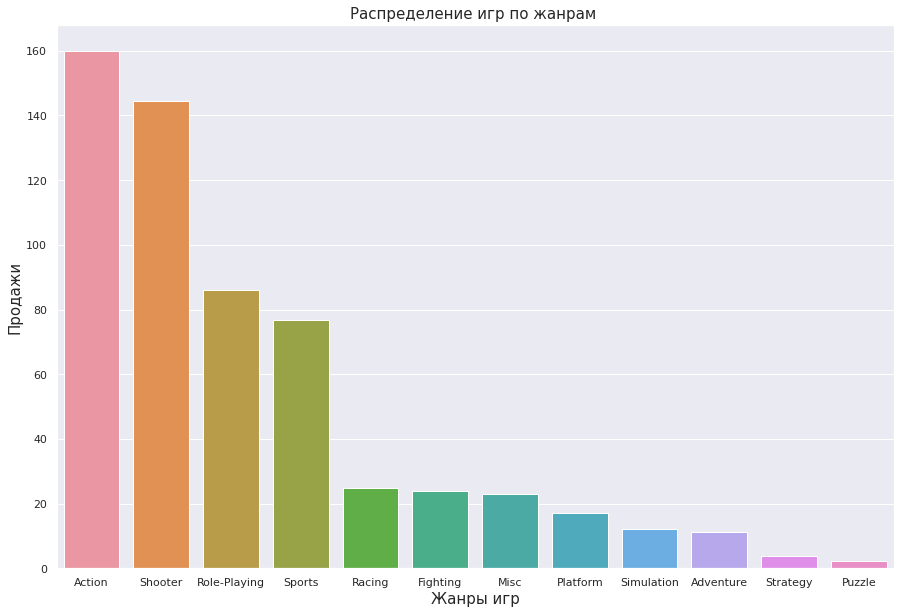

In [37]:
# Изобразим количество продаж игр различных жанров
plt.figure(figsize=(15,10))
plt.title('Распределение игр по жанрам ',fontsize=15)
sns.barplot(data=genre_data, x='genre', y='total_sales')
plt.xlabel('Жанры игр',fontsize=15)
plt.ylabel('Продажи',fontsize=15)

In [38]:
modern_data.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,619.0,0.322068,0.798181,0.01,0.0300,0.090,0.2800,12.62
Adventure,185.0,0.094865,0.203147,0.01,0.0200,0.030,0.0800,1.66
Fighting,60.0,0.470333,1.188053,0.01,0.0600,0.125,0.3200,7.55
Misc,113.0,0.332301,0.736999,0.01,0.0300,0.090,0.3200,5.27
Platform,38.0,0.476053,0.722561,0.01,0.0625,0.140,0.4675,3.21
Puzzle,14.0,0.157857,0.320629,0.01,0.0200,0.045,0.1000,1.19
Racing,69.0,0.398841,0.963716,0.01,0.0300,0.090,0.2500,7.09
Role-Playing,221.0,0.459005,1.177284,0.01,0.0500,0.110,0.3600,11.68
Shooter,128.0,1.335469,2.050567,0.01,0.1725,0.515,1.6175,14.63


Text(0, 0.5, 'Жанр')

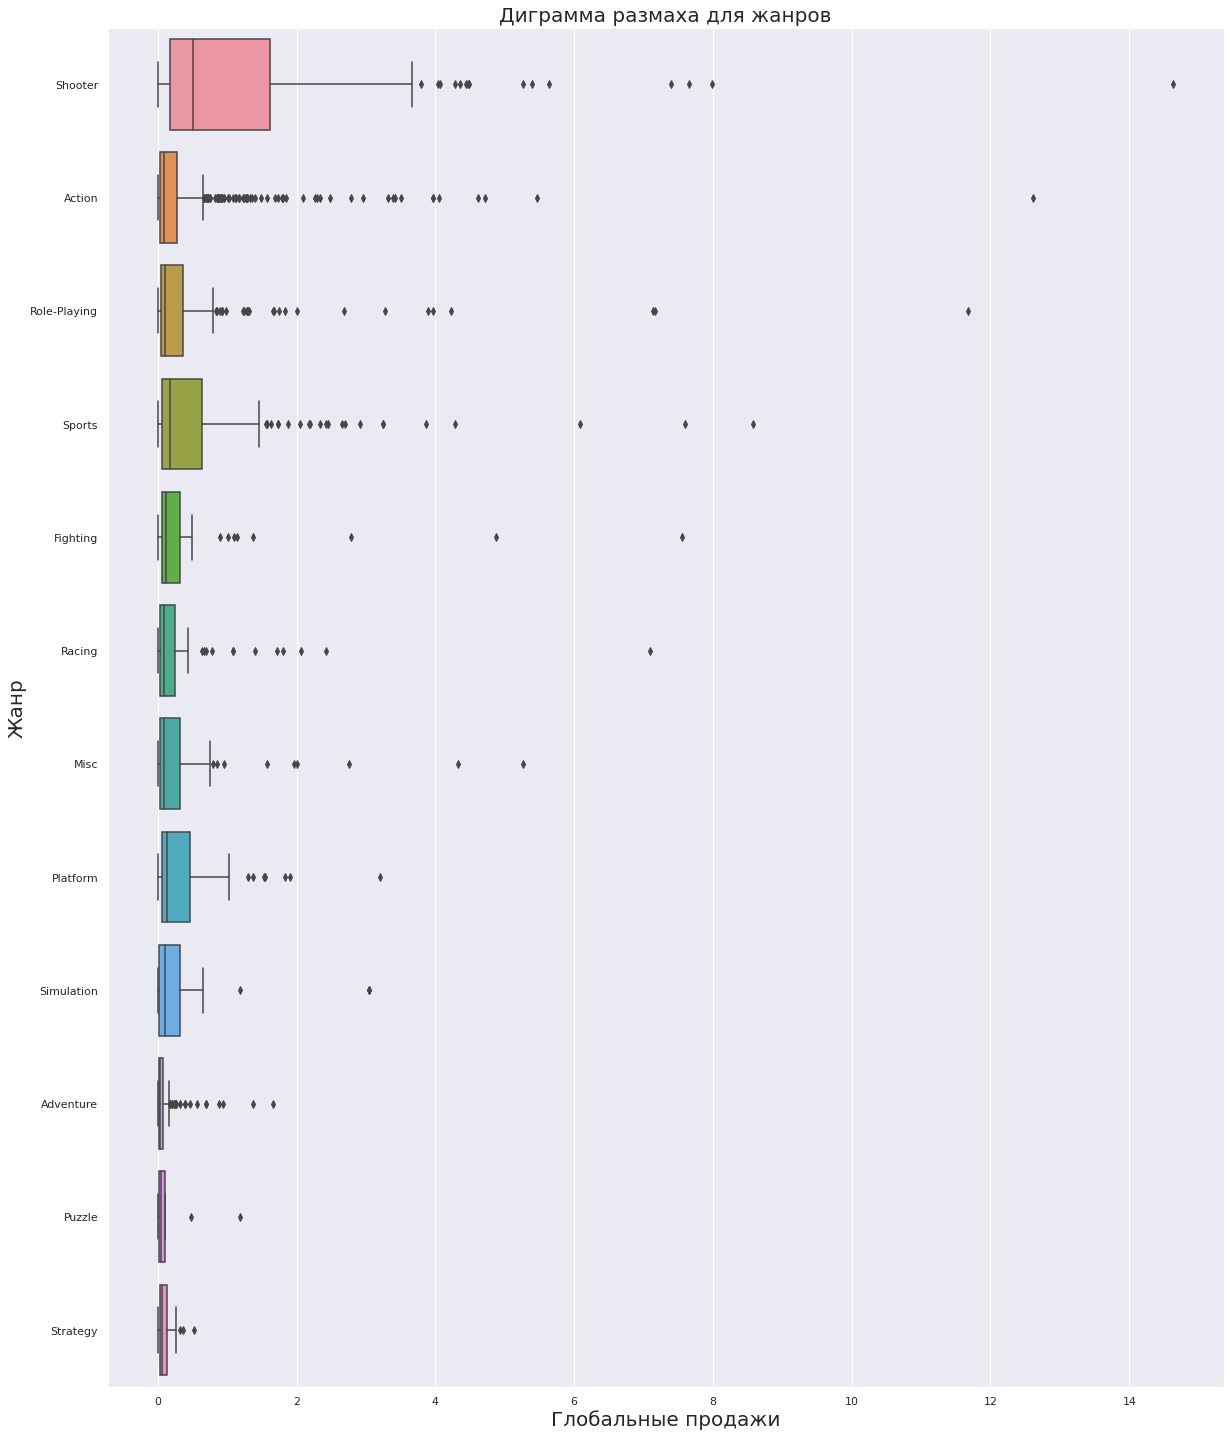

In [39]:
# Диаграмма размаха 
plt.figure(figsize=(20,25))
sns.boxplot(data=modern_data, x='total_sales', y='genre', orient = "h")
plt.title('Диграмма размаха для жанров', fontsize=20)
plt.xlabel('Глобальные продажи', fontsize=20)
plt.ylabel('Жанр',fontsize=20)

(0.0, 4.0)

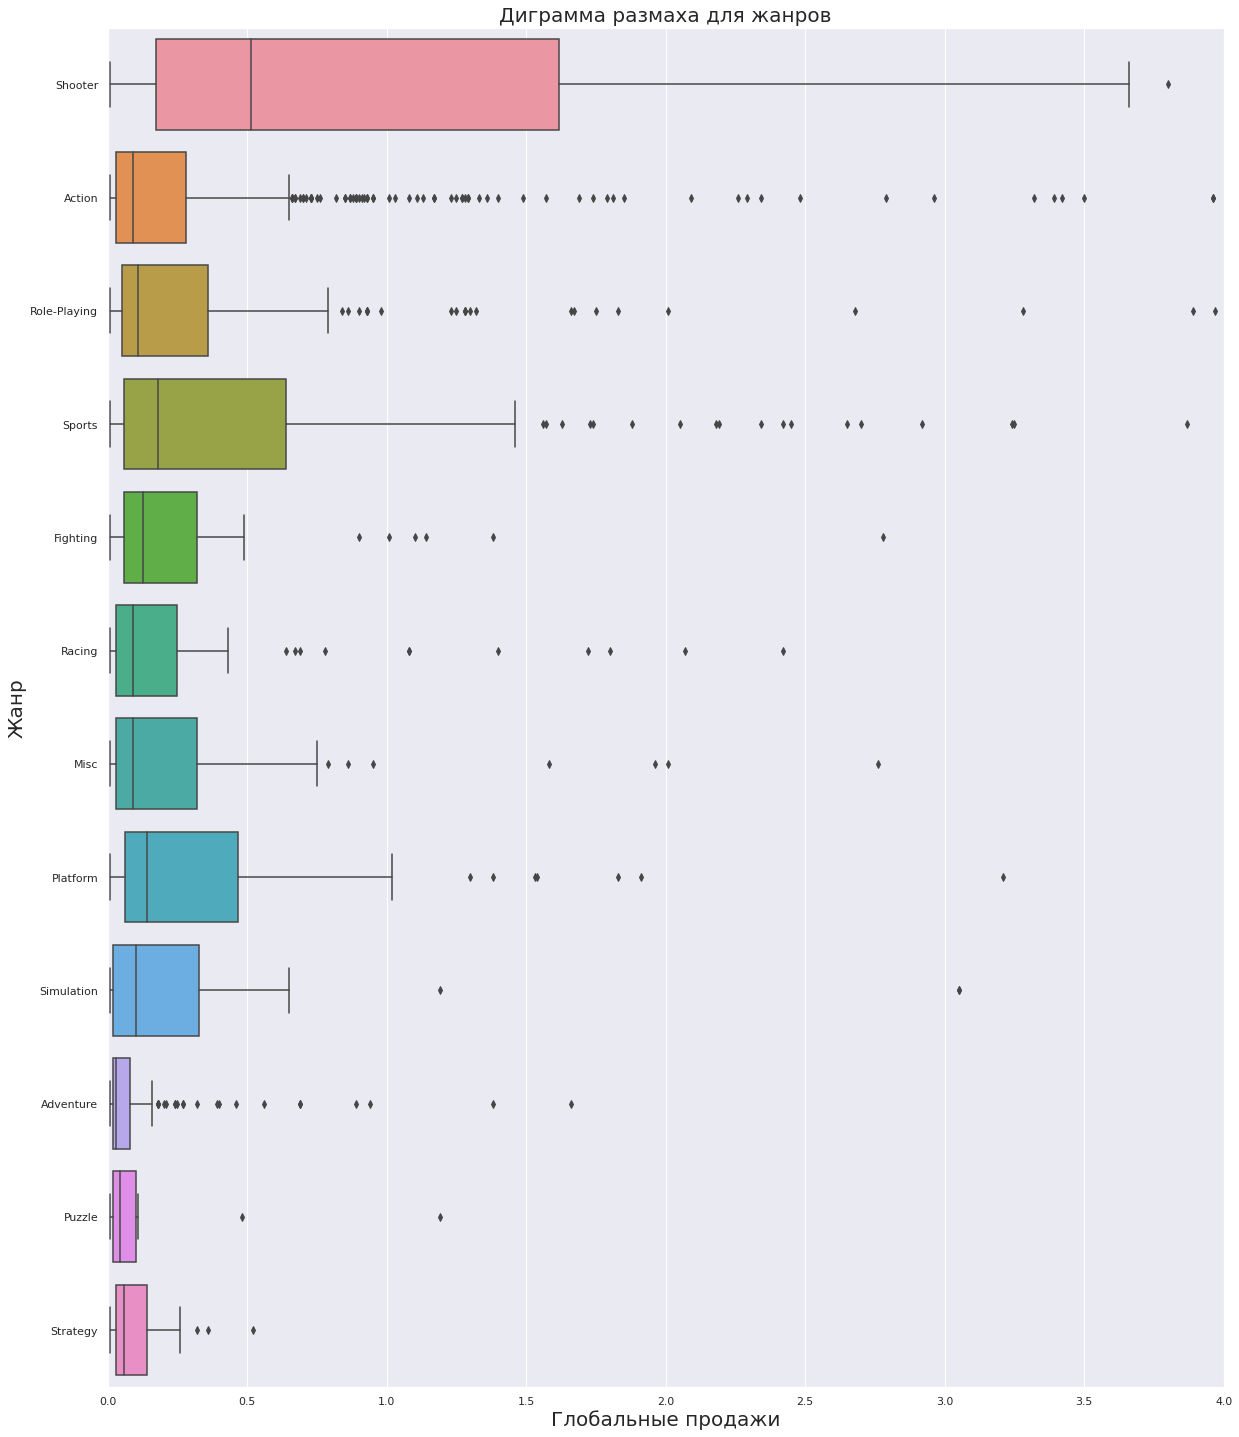

In [40]:
# Диаграмма размаха без выбросов
plt.figure(figsize=(20,25))
sns.boxplot(data=modern_data, x='total_sales', y='genre', orient = "h")
plt.title('Диграмма размаха для жанров', fontsize=20)
plt.xlabel('Глобальные продажи', fontsize=20)
plt.ylabel('Жанр',fontsize=20)
plt.xlim(0, 4)

Самым спросовым оказался жанр Action, пазлы же спросом не пользуются.

In [41]:
shooter_data = modern_data[modern_data['genre'] == 'Shooter']
display(shooter_data.head(20))
print(shooter_data['total_sales'].median())

action_data = modern_data[modern_data['genre'] == 'Action']
display(action_data.head(20))
print(action_data['total_sales'].median())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,TBD,14.63
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,TBD,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,TBD,7.39
154,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26
242,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47
247,Splatoon,WiiU,2015,Shooter,1.54,1.18,1.46,0.26,81.0,8.5,E10+,4.44


0.515


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
225,The Last of Us,PS4,2014,Action,1.88,2.00,0.07,0.77,NaN,NaN,TBD,4.72
231,Uncharted: The Nathan Drake Collection,PS4,2015,Action,2.07,1.71,0.08,0.76,86.0,8.1,T,4.62
295,Watch Dogs,PS4,2014,Action,1.40,1.90,0.11,0.64,80.0,6.3,M,4.05
304,Assassin's Creed: Unity,PS4,2014,Action,1.19,2.07,0.08,0.62,70.0,4.9,M,3.96
305,Batman: Arkham Knight,PS4,2015,Action,1.53,1.69,0.10,0.64,87.0,7.6,M,3.96
373,Assassin's Creed: Unity,XOne,2014,Action,2.27,0.90,0.00,0.33,72.0,4.1,M,3.50
390,Metal Gear Solid V: The Phantom Pain,PS4,2015,Action,1.09,1.36,0.49,0.48,93.0,8.2,M,3.42
396,Assassin's Creed Syndicate,PS4,2015,Action,0.81,1.99,0.07,0.52,76.0,6.8,M,3.39


0.09


Вывод по разделу: Самымии популярными платформами за выбранный акутальный период оказались PC, 3DS, WiiU, XOne и PS4. Средний срок, пока платформа остается актуальной, - 5-8 лет, а исчезает платформа примерно за 5 лет. PC  в свою очередь держится с переменным успехом. В выбранном акутальном периоде заметен спад продаж игр для PC, который может быть связан с ростом доступности и популярности консолей и с развитием мобильного гейминга. Больше всего продаж было у XOne и PS4. Выявлена слабая зависимость продаж от оценок критиков, а оценки пользователей на продажи не влияют. Самый популярный жанр игр - 'Action', самый непопулярный - пазлы.

# Шаг 4. Составление портрета пользователя каждого региона

Расчет самых популярных платформ.

Напишем функцию, которая будет принимать имя региона и название столбца, по которому будет происходить расчет.

In [42]:
regions = ['na_sales','eu_sales','jp_sales']
def top_5(region, by_col):
 df_temp = modern_data.groupby(by=by_col)[region].agg('sum').sort_values(ascending=False).to_frame()
 top_5 = df_temp[:5].index
 df_temp.index = df_temp.index.where(df_temp.index.isin(top_5),'Other')
 return df_temp.groupby(by=df_temp.index)[region].agg('sum').sort_values(ascending=False)

# Выделим из актуальной таблицы данные с топовыми платформами по каждому региону
top_5_sales_by_regions = pd.concat([top_5(regions[0], 'platform'),
 top_5(regions[1], 'platform'),
 top_5(regions[2], 'platform')], axis=1)
top_5_sales_by_regions

,na_sales,eu_sales,jp_sales
platform,,,
PS4,98.61,130.04,15.02
XOne,81.27,46.25,NaN
Other,31.19,34.76,0.76
X360,28.30,NaN,NaN
3DS,22.64,16.12,44.24
PS3,22.05,25.54,11.22
PC,NaN,17.97,NaN
PSV,NaN,NaN,14.54
WiiU,NaN,NaN,7.31


(-1.25, 1.25, -1.25, 1.25)

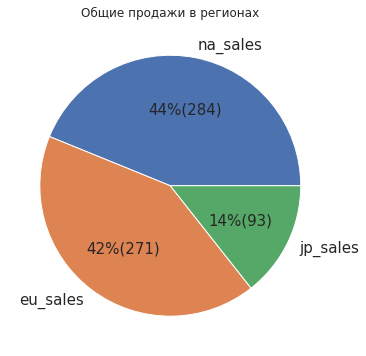

In [43]:
ax = top_5_sales_by_regions.sum().plot(
    kind='pie',
    autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*top_5_sales_by_regions.sum().sum()),
    textprops={'fontsize': 15},
    figsize=(6,6),
    title='Общие продажи в регионах')

ax.axis('off')

Больше всего игр продавалось в Северной Америке, а меньше всего в Японии.

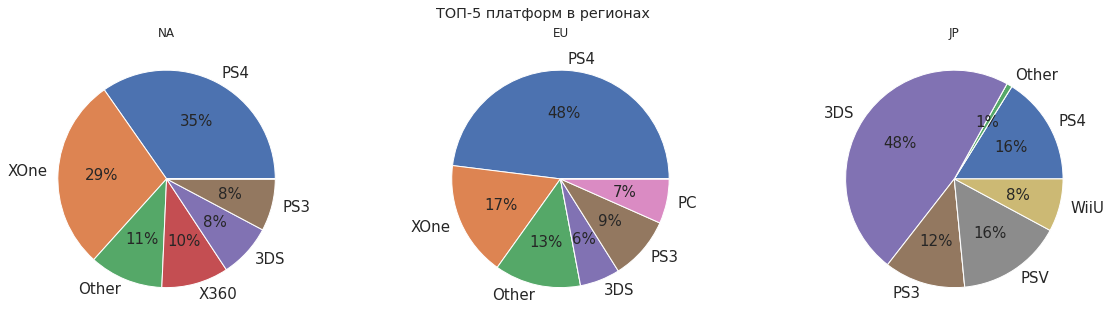

In [44]:
#Топ платформ по регионам
axes = top_5_sales_by_regions.plot.pie(subplots=True,
                                figsize=(20, 5),
                                autopct=lambda p: '{:.0f}%'.format(p) if p > 0 else '',
                                textprops={'fontsize': 15},
                                legend=False,
                                title='ТОП-5 платформ в регионах')
for id_,ax in enumerate(axes):
    ax.axis('off')
    ax.set_title(regions[id_].upper().split('_')[0])

#### В Северной Америке самой распространенной оказалась PS4, также хорошей популярностью пользуются XOne. В Европе также лидируют PS4 и XOne. В Японии абсолютное большинство рынка заняла 3DS, а второй по полурярности является PS4. ожно отметить, что PS4 пользуется хорошей популярностью во всех регионах.

Расчет самых популярных жанров.

In [45]:
top_5_sales_by_genre = pd.concat([top_5(regions[0], 'genre'),
                                    top_5(regions[1], 'genre'),
                                    top_5(regions[2], 'genre')], axis=1)
top_5_sales_by_genre

,na_sales,eu_sales,jp_sales
genre,,,
Shooter,79.02,65.52,4.87
Action,72.53,74.68,29.58
Sports,46.13,45.73,NaN
Other,37.86,42.45,15.50
Role-Playing,33.47,28.17,31.16
Misc,15.05,NaN,5.61
Racing,NaN,14.13,NaN
Fighting,NaN,NaN,6.37


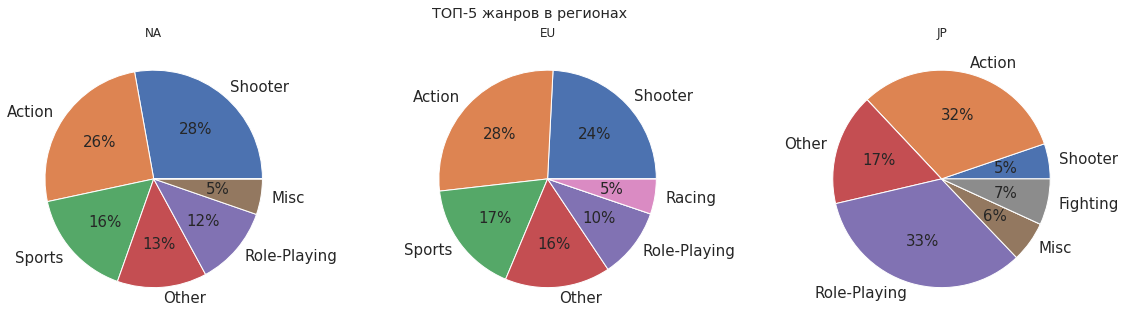

In [46]:
axes = top_5_sales_by_genre.plot.pie(subplots=True,
                                figsize=(20, 5),
                                autopct=lambda p: '{:.0f}%'.format(p) if p > 0 else '',
                                textprops={'fontsize': 15},
                                legend=False,
                                title='ТОП-5 жанров в регионах')
for id_,ax in enumerate(axes):
    ax.axis('off')
    ax.set_title(regions[id_].upper().split('_')[0])

В Америке первым по популярности является жанр Shooter, а вторым - Action. В Европе лидирующие позиции распределились наоборот. В Японии, как и в других регионах, жанр Action занимает большой объем рынка, но больше всего популярен жанр Role-Playing. Также Япония проявляет существенный интерес к множеству других жанров (17%). Жанр Action пользуется большой популярностью во всех регионах, а в Европе и Америке также достаточно популярны спортивные игры.

Влияние рейтинга ESRB на продажи

In [47]:
#Сгруппируем  рейтинг ESRB по суммарным продажам по каждому региону
def get_ESRB(region, by_col):
    return modern_data.groupby(by=by_col)[region].agg('sum').sort_values(ascending=False)

sales_ESRB = pd.concat([get_ESRB(regions[0], 'rating'),
                           get_ESRB(regions[1], 'rating'),
                           get_ESRB(regions[2], 'rating')], axis=1)
sales_ESRB

,na_sales,eu_sales,jp_sales
rating,,,
M,96.42,93.44,8.01
TBD,64.72,58.95,56.90
E,50.74,58.06,8.94
T,38.95,34.07,14.78
E10+,33.23,26.16,4.46


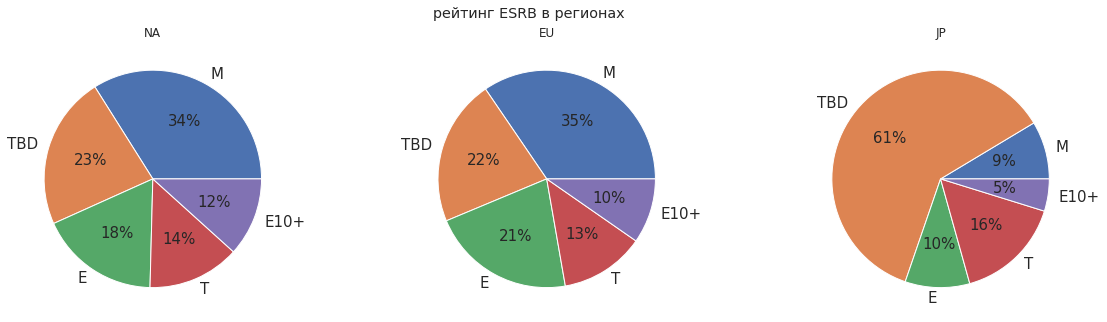

In [48]:
axes = sales_ESRB.plot.pie(subplots=True,
                                figsize=(20, 5),
                                autopct=lambda p: '{:.0f}%'.format(p) if p > 0 else '',
                                textprops={'fontsize': 15},
                                legend=False,
                                title='рейтинг ESRB в регионах')
for id_,ax in enumerate(axes):
    ax.axis('off')
    ax.set_title(regions[id_].upper().split('_')[0])

В Европе и Северной америке чаще всего покупали игры с рейтингом М, доля игр с неопознанным рейтингом в обоих регионах занимает 2-е место (23% и 22% соответственно), на третьем месте после неопознанного рейтинга стоит рейтинг Е. В Японии самое широкое распространение получили игры с неопознанным рейтингом, на втором месте расположился рейтинг Т, а игры с рейтингом Е и М заняли 3-е и 4-е место соответственно.

Общий вывод по портрету.
По количеству продаваемых игр регионы расположились по убыванию следующим образом: Северная Америка, Европа и Япония.
В Европе и Северной Америке лидирующими платформами оказались XBox360, PS3 и PS4, в Японии лидируют 3DS и PS3.
Жанр shooter является лидером у Америки, а на втором месте здесь жанр action, в Европе эти жанры распределились в обратном порядке по популярности. В Японии жанр action занимает второе место после role-playing. Также в Японии широко распространены игры множества других жанров. Стоит отметить, что в Европе и Америке широко распространены спортивные игры, а жанр action пользуется хорошим спросом во всех регионах.
В Европе и Северной америке чаще всего покупали игры с рейтингом М, доля игр с неопознанным рейтингом в обоих регионах занимает 2-е место (23% и 22% соответственно), на третьем месте после неопознанного рейтинга стоит рейтинг Е. В Японии самое широкое распространение получили игры с неопознанным рейтингом, на втором месте расположился рейтинг Т, а игры с рейтингом Е и М заняли 3-е и 4-е место соответственно.

# Шаг 5: проверка гипотез.

 Проверим гипотезы:
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
 
 Зададим самостоятельно пороговое значение alpha.

 Поясним:
Как  сформулировались нулевая и альтернативная гипотезы;
Какой критерий применялся для проверки гипотез и почему.

Гипотеза о равном среднем пользовательском рейтинге у платформ Xbox One и PC.

In [49]:
# Сохраним в отдельные переменные данные о платформах
xbox_one = strim_data[(strim_data['platform'] == 'XOne') & (strim_data['year_of_release'] > 2013)]['user_score']
pc = strim_data[(strim_data['platform'] == 'PC') & (strim_data['year_of_release'] > 2013)]['user_score']

#Выведем средний рейтинг
print('Средний рейтинг пользователей для XBoxOne', xbox_one.mean())
print('Средний рейтинг пользователей для PC', pc.mean())

Средний рейтинг пользователей для XBoxOne 6.594545454545454
Средний рейтинг пользователей для PC 6.298360655737704


H0: средние пользовательские рейтинги равны.   
Альтернативная гипотеза: средние пользовательские рейтинги не равны.

In [50]:
#проверяем гипотезы
alpha = 0.01

results = st.ttest_ind(xbox_one.dropna(), pc.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Выборки разные по размеру, поэтому выставили границы альфа побольше - 1%. Выдвинули нулевую гипотезу о равном среднем рейтинге для платформ и противоположную ей альтернативную. Проверка выявила, что нет оснований отвергать нулевую гипотезу. Это верно, потому что средние рейтинги практически равны.

Гипотеза о разности средних пользовательских рейтингов жанров Action и Sports.

In [52]:
# Сохраним в отдельные переменные данные о жанрах
action_df = strim_data[(strim_data['genre'] == 'Action') & (strim_data['year_of_release'] > 2011)]['user_score']
sports_df = strim_data[(strim_data['genre'] == 'Sports') & (strim_data['year_of_release'] > 2011)]['user_score']

#Выведем средний рейтинг
print('Средний рейтинг жанра Action', action_df.mean())
print('Средний рейтинг жанра Sports', sports_df.mean())

Средний рейтинг жанра Action 6.825047801147227
Средний рейтинг жанра Sports 5.455670103092784


Н0:Средние пользовательские рейтинги жанров Action и Sports равны.   
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports не равны.

In [53]:
#проверяем гипотезы
alpha = 0.01

results = st.ttest_ind(action_df.dropna(), sports_df.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.989458066467418e-20
Отвергаем нулевую гипотезу


Проверка отвергла нулевую гипотезу о равном значении рейтингов. Приведенные выше средние пользовательские оценки для каждого жанра наглядно показывают разницу.


# Общий вывод

  Перед началом работы я изменил все необходимые форматы данных, привел названия столбцов к нужному регистру, удалил ненужные строки. Узнал, что аббревиатура TBD означает не пропуск, а то, что игра ожидает оценки. Все значения TBD заменил на nan.
  Проведя анализ, я узнал, среднее время актуальности платформы составляет примерно 8 лет, а "гибель" платформы наступает примерно за 5 лет. На основе полученных данных был выбран акутальный период для анализа - с 2013 по 2016.
  К 2016 году прибыльными оставались несколько платформ: XOne, 3DS, WiiU, PC и PS4, остальные либо находились на закате, либо были уже не актуальны. Платформой, которая будет в дальнейшем пользоваться спросом можно назвать PC.
  Зависимости между отзывами пользователей и продажами не выявлено, есть небольшая зависимость продаж от оценки критиков. Большой популярностью во всех регионах пользуется жанр Action. Больше всего игры продавались в Северной Америке.
  По количеству продаваемых игр регионы расположились по убыванию следующим образом: Северная Америка, Европа и Япония.
В Европе и Северной Америке лидирующими платформами оказались XBoxOne и PS4, в Японии лидируют 3DS, PS4 и PSV.
  В Америке первым по популярности является жанр Shooter, а вторым - Action. В Европе лидирующие позиции распределились наоборот. В Японии, как и в других регионах, жанр Action занимает большой объем рынка, но больше всего популярен жанр Role-Playing. Также Япония проявляет существенный интерес к множеству других жанров (17%). Жанр Action пользуется большой популярностью во всех регионах, а в Европе и Америке также достаточно популярны спортивные игры.
  В Европе и Северной америке чаще всего покупали игры с рейтингом М, доля игр с неопознанным рейтингом в обоих регионах занимает 2-е место (23% и 22% соответственно), на третьем месте после неопознанного рейтинга стоит рейтинг Е. В Японии самое широкое распространение получили игры с неопознанным рейтингом, на втором месте расположился рейтинг Т, а игры с рейтингом Е и М заняли 3-е и 4-е место соответственно.
  Проверка гипотез показала, что пользовательские рейтинги у XBoxOne и PC совпадают. Пользовательские рейтинги жанров Action и Sports различаются, у Action оценки выше.